In [139]:
import time
from collections import deque

# -------- Image processing -----
import pyautogui
import numpy as np
import cv2
import mss

# -------- TensorFlow / Keras ----
import tensorflow as tf
from tensorflow.keras import layers, Model

# -------- Misc / Debug ----------
import matplotlib.pyplot as plt
import wandb

print("All imports successful for Run3 project!")
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"OpenCV version: {cv2.__version__}")


All imports successful for Run3 project!
TensorFlow version: 2.15.0
NumPy version: 1.26.4
OpenCV version: 4.10.0


In [140]:
#Establish some variables and params for later

#number of frames to feed model at a time. We input to the model the FRAME_STACK most recent frames
FRAME_STACK = 4

#variables for the location of the run 3 game on the screen. This is for Malcolms computer, if its diff for u make new vars
TOP_X = 275
TOP_Y = 195
WIDTH = 725
HEIGHT = 545

GAMEOVER_X = 860
GAMEOVER_Y = 435
GAMEOVER_W = 70
GAMEOVER_H = 45

RUNWAY_X = 600
RUNWAY_Y = 480
RUNWAY_W = 75
RUNWAY_H = 180

RUNWAY_REWARD = 3

#Which device is running the game. Add ur own if u wanna train. So we dont have to go all the way through everything and change
MAC_LAPTOP = True 
MAC_MONITOR = False

if MAC_LAPTOP: 
    TOP_X = 275
    TOP_Y = 195
    WIDTH = 725
    HEIGHT = 545

    GAMEOVER_X = 860
    GAMEOVER_Y = 435
    GAMEOVER_W = 70
    GAMEOVER_H = 45

    RUNWAY_X = 600
    RUNWAY_Y = 480
    RUNWAY_W = 75
    RUNWAY_H = 180 #made this a bit longer to try and get the agent to move over the platforms when its mid-jump


#resolution of the image were resizing to. This affects the input to our neural net directly.
RESOLUTION = 128

#number of actions the model can take. This is a super important thing to change if the model isnt training well. As of 12/5 were starting
#with the model being able to take [no action, L_small, R_small, U_small, L_med, R_med ...etc.]
NUM_ACTIONS = 11


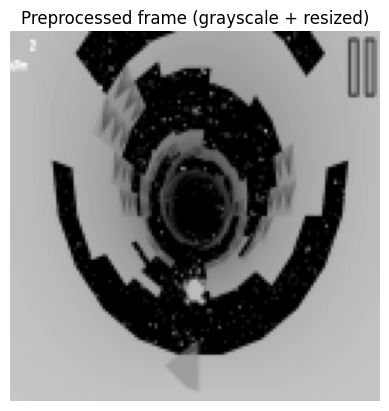

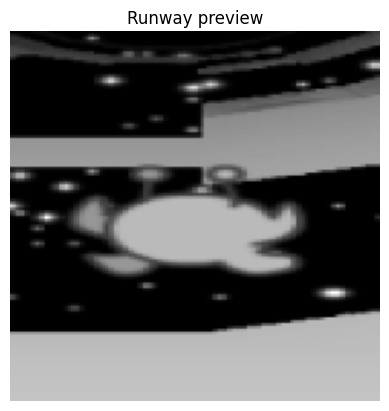

In [141]:
def preprocess_frame(image, resize=(RESOLUTION, RESOLUTION), gray=True):
    """
    Captures a screenshot of the given region, converts to grayscale, resizes.
    Returns numpy array of shape (resize[1], resize[0]).
    """
    if gray:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Resize deterministically
    small = cv2.resize(image, resize, interpolation=cv2.INTER_AREA)
    
    return small

def stack_frames(frames, new_frame, stack_size=FRAME_STACK):
    """
    Maintains a stack of frames to capture motion.
    frames: deque of previous frames
    new_frame: newest preprocessed frame
    Returns stack of frames
    """
    if len(frames) == 0:
        # Initialize with repeated frame
        for _ in range(stack_size):
            frames.append(new_frame)
    else:
        frames.append(new_frame)
        if len(frames) > stack_size:
            frames.popleft()
    return np.stack(frames, axis=0)

#TEST to see if screen grab is working

time.sleep(3)

sct = mss.mss()
monitor = {
    "top": TOP_Y,
    "left": TOP_X,
    "width": WIDTH,
    "height": HEIGHT
}

runway = {
    "top": RUNWAY_Y,
    "left": RUNWAY_X,
    "width": RUNWAY_W,
    "height": RUNWAY_H
}
screenshot = np.array(sct.grab(monitor))
img = cv2.cvtColor(np.array(screenshot), cv2.COLOR_BGRA2BGR)
processed = preprocess_frame(img)
plt.imshow(processed, cmap="gray")
plt.title("Preprocessed frame (grayscale + resized)")
plt.axis("off")
plt.show()

screenshot = np.array(sct.grab(runway))
img = cv2.cvtColor(np.array(screenshot), cv2.COLOR_BGRA2BGR)
processed = preprocess_frame(img)
plt.imshow(processed, cmap="gray")
plt.title("Runway preview")
plt.axis("off")
plt.show()

In [142]:
class PPOActorCritic(tf.keras.Model):
    def __init__(self, input_channels=FRAME_STACK, num_actions=NUM_ACTIONS):
        super(PPOActorCritic, self).__init__()

        # TensorFlow expects channels-last → (RESOLUTION, RESOLUTION, C)
        self.input_channels = input_channels
        self.num_actions = num_actions
        
        # ---------- CNN Backbone ----------
        self.conv1 = layers.Conv2D(32, kernel_size=8, strides=4, activation='relu')
        self.conv2 = layers.Conv2D(64, kernel_size=4, strides=2, activation='relu')
        self.conv3 = layers.Conv2D(64, kernel_size=3, strides=1, activation='relu')

        #max pool? think about max pool if we use a larger resolution. But these convs also scale down.

        # compute flatten size
        self._conv_out_size = self._get_conv_out((RESOLUTION, RESOLUTION, input_channels))

        # ---------- Shared Fully Connected ----------
        self.fc = layers.Dense(512, activation='relu')

        # ---------- Actor Head ----------
        self.actor_fc1 = layers.Dense(64, activation='relu')
        self.actor_logits = layers.Dense(num_actions, activation=None)

        # ---------- Critic Head ----------
        self.critic_fc1 = layers.Dense(64, activation='relu')
        self.critic_value = layers.Dense(1, activation=None)

    # -------------------------------------------------
    # Compute conv output size by running dummy tensor. This saves us work if we change the CNN structure
    # -------------------------------------------------
    def _get_conv_out(self, shape):
        dummy = tf.zeros((1, *shape), dtype=tf.float32)
        x = self.conv1(dummy)
        x = self.conv2(x)
        x = self.conv3(x)
        return int(np.prod(x.shape[1:]))

    # -------------------------------------------------
    # Forward pass
    # -------------------------------------------------
    def call(self, x):
        """
        x expected as (batch, RESOLUTION, RESOLUTION, 4)
        """
        x = tf.cast(x, tf.float32) / 255.0 #normalize to [0,1]

        # CNN backbone
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # Flatten
        x = tf.reshape(x, (x.shape[0], -1))

        # Shared FC
        x = self.fc(x)

        # ---- Actor ----
        a = self.actor_fc1(x)
        logits = self.actor_logits(a)

        # ---- Critic ----
        c = self.critic_fc1(x)
        value = self.critic_value(c)

        return logits, value

In [143]:
class Run3Env:
    def __init__(self, region=(TOP_X, TOP_Y, WIDTH, HEIGHT), frame_stack=FRAME_STACK):
        self.region = region
        self.frame_stack = frame_stack #integer, not the actual stack. Do we need instance var?
        self.frames = deque(maxlen=frame_stack)

        self.prev_runw_reward = 0
        self.num_consecutive = 0

        self.sct = mss.mss()
        self.monitor = {
            "top": region[1],      # TOP_Y
            "left": region[0],     # TOP_X
            "width": region[2],    # WIDTH
            "height": region[3]    # HEIGHT
        }

    # -------------------------
    # Reset environment
    # -------------------------
    def reset(self):
        # Click to restart game. 900,650 is just off the screen a bit, click twice to bypass the "continue" and "score". 
        #we can also press a button to make it better for everyones computer
        time.sleep(.7)
        pyautogui.click(900, 650)
        time.sleep(.7)
        pyautogui.click(900, 650)
        self.frames.clear()

        # Get initial observation
        raw = self.capture_raw()
        processed = preprocess_frame(raw) #function defined at the top
        stacked = stack_frames(self.frames, processed)
        return np.transpose(stacked, (1, 2, 0))  # (RESOLUTION, RESOLUTION, FRAME_STACK). 

    # -------------------------
    # Capture raw screenshot
    # -------------------------
    def capture_raw(self):
        screenshot = np.array(self.sct.grab(self.monitor))
        # mss returns BGRA, convert to BGR. Also mss is much faster than pyautogui so we use it for more fps.
        img = cv2.cvtColor(screenshot, cv2.COLOR_BGRA2BGR)
        return img

    # -------------------------
    # Detect game over
    # -------------------------
    def game_over(self, raw_frame): #FIX
        """Check if dialog region is white"""
        # Extract region. Note hard coded values are for macs laptop, its a region of the screen where its all white on game over.
        tlx = GAMEOVER_X - TOP_X
        tly = GAMEOVER_Y - TOP_Y
        w = GAMEOVER_W
        h = GAMEOVER_H
        roi = raw_frame[tly:tly+h, tlx:tlx+w]
        
        # Check if white directly on BGR image
        mean_val = roi.mean()  # Average across all pixels AND all channels

        # If all channels are ~255, mean will be ~255
        return mean_val > 250

    def runway_reward(self, raw_frame):
        tlx = RUNWAY_X - TOP_X
        tly = RUNWAY_Y - TOP_Y
        w = RUNWAY_W
        h = RUNWAY_H
        roi = raw_frame[tly:tly+h, tlx:tlx+w]

        if len(roi.shape) == 3: #grayscale
            roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        else:
            roi_gray = roi
        
        platform_pixels = np.sum(roi_gray > 20)
        total_pixels = roi_gray.size
        platform_ratio = platform_pixels / total_pixels

        #PENALIZE PLATFORMS ON LEFT SIDE
        slx = 425 - TOP_X
        sly = 325 - TOP_Y
        w = 100
        h = 250
        sl = raw_frame[sly:sly+h, slx:slx+w]
        if len(sl.shape) == 3: #grayscale
            sl_gray = cv2.cvtColor(sl, cv2.COLOR_BGR2GRAY)
        else:
            sl_gray = sl
        sl_pixels = np.sum(sl_gray > 20)
        total_pixels = sl_gray.size
        sl_ratio = sl_pixels / total_pixels

        #PENALIZE PLATFORMS ON RIGHT SIDE
        srx = 750 - TOP_X
        sry = 325 - TOP_Y
        w = 100
        h = 250
        sr = raw_frame[sry:sry+h, srx:srx+w]
        if len(sr.shape) == 3: #grayscale
            sr_gray = cv2.cvtColor(sr, cv2.COLOR_BGR2GRAY)
        else:
            sr_gray = sr
        sr_pixels = np.sum(sr_gray > 20)
        total_pixels = sr_gray.size
        sr_ratio = sr_pixels / total_pixels
        
        return RUNWAY_REWARD * (platform_ratio  - 0.2 * (sl_ratio * .5 + sr_ratio * .5))

    # -------------------------
    # Take one step in environment 
    # -------------------------
    def step(self, action): #NOT FINISHED DONT TOUCH
        # step_start = time.time()
        self._execute_action(action)

        # Capture new frame
        raw = self.capture_raw()

        done = self.game_over(raw) #Boolean var

        # Reward logic
        if done:
            reward = -25
        else:
            runway_reward = self.runway_reward(raw)
            if runway_reward == self.prev_runw_reward:
                self.num_consecutive += 1
            else:
                self.num_consecutive = 0
            self.prev_runw_reward = runway_reward
            reward = 1 + runway_reward 

        if self.num_consecutive > 10:
            pyautogui.keyDown("up")
            time.sleep(.01)
            pyautogui.keyUp("up")
        
        # Preprocess
        processed = preprocess_frame(raw)
        stacked = stack_frames(self.frames, processed)
        
        state = np.transpose(stacked, (1, 2, 0))  # (REOSLUTION,RESOLUTION,STACK_FRAMES)

        # TARGET_TIMESTEP = 0.33 
        # elapsed = time.time() - step_start
        # if elapsed < TARGET_TIMESTEP:
        #     time.sleep(TARGET_TIMESTEP - elapsed)

        return state, reward, done, {}

    def _execute_action(self, action):
        """Execute action with proper hold durations"""
    
        # Map actions to (keys, duration_seconds)
        # keys can be a tuple for combos
        action_config = {
            0: (None, 0),                # No action
            1: (('left',), 0.05),
            2: (('right',), 0.05),
            3: (('up',), 0.05),
            4: (('left',), 0.25),
            5: (('right',), 0.25),
            6: (('up',), 0.25),
            7: (('left', 'up'), 0.05),
            8: (('right', 'up'), 0.05),
            9: (('left', 'up'), 0.25),
            10: (('right', 'up'), 0.25),
        }
    
        keys, duration = action_config[action]
    
        if keys is not None:
            # Press down all keys in the combo
            for k in keys:
                pyautogui.keyDown(k)
    
            time.sleep(duration)
    
            # Release all keys
            for k in keys:
                pyautogui.keyUp(k)

In [144]:
# #JUST FOR TESTING THINGS WORK WHEN RUNNING THE GAME.
# sct = mss.mss()
# monitor = {
#     "top": TOP_Y,
#     "left": TOP_X,
#     "width": WIDTH,
#     "height": HEIGHT
# }
# num_g_over = 0
# prev_runw_reward = 0
# num_consecutive = 0

# def test_game_over(raw_frame):
#     """Check if dialog region is white"""
#     # Extract region
#     tlx = 860 - TOP_X
#     tly = 435 - TOP_Y
#     w = 70
#     h = 45
#     roi = raw_frame[tly:tly+h, tlx:tlx+w]
    
#     # Check if white directly on BGR image
#     mean_val = roi.mean()  # Average across all pixels AND all channels
    
#     # If all channels are ~255, mean will be ~255
#     return mean_val > 250

# def test_runway_reward(raw_frame):
#     tlx = RUNWAY_X - TOP_X
#     tly = RUNWAY_Y - TOP_Y
#     w = RUNWAY_W
#     h = RUNWAY_H
#     roi = raw_frame[tly:tly+h, tlx:tlx+w]

#     if len(roi.shape) == 3: #grayscale
#         roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
#     else:
#         roi_gray = roi
    
#     platform_pixels = np.sum(roi_gray > 20)
#     total_pixels = roi_gray.size
#     platform_ratio = platform_pixels / total_pixels

#     #PENALIZE PLATFORMS ON LEFT SIDE
#     slx = 350 - TOP_X
#     sly = 325 - TOP_Y
#     w = 100
#     h = 250
#     sl = raw_frame[sly:sly+h, slx:slx+w]
#     if len(sl.shape) == 3: #grayscale
#         sl_gray = cv2.cvtColor(sl, cv2.COLOR_BGR2GRAY)
#     else:
#         sl_gray = sl
#     sl_pixels = np.sum(sl_gray > 20)
#     total_pixels = sl_gray.size
#     sl_ratio = sl_pixels / total_pixels

#     #PENALIZE PLATFORMS ON RIGHT SIDE
#     srx = 825 - TOP_X
#     sry = 325 - TOP_Y
#     w = 100
#     h = 250
#     sr = raw_frame[sry:sry+h, srx:srx+w]
#     if len(sr.shape) == 3: #grayscale
#         sr_gray = cv2.cvtColor(sr, cv2.COLOR_BGR2GRAY)
#     else:
#         sr_gray = sr
#     sr_pixels = np.sum(sr_gray > 20)
#     total_pixels = sr_gray.size
#     sr_ratio = sr_pixels / total_pixels
    
#     return RUNWAY_REWARD * (platform_ratio  - 0.2 * (sl_ratio * .5 + sr_ratio * .5))

# while True:
#     start_time = time.time()
#     screenshot = np.array(sct.grab(monitor))
#     img = cv2.cvtColor(screenshot, cv2.COLOR_BGRA2BGR)
#     if test_game_over(img):
#         num_g_over += 1
#         print(f"\rgame over {num_g_over}", end='', flush=True)
#         time.sleep(0.7)
#         pyautogui.click(900, 650)
#         time.sleep(0.7)
#         pyautogui.click(900, 650)
#     else:
#         runway_reward = test_runway_reward(img)
#         if runway_reward == prev_runw_reward:
#             num_consecutive += 1
#         else:
#             num_consecutive = 0
#         prev_runw_reward = runway_reward
#         reward = 1 + runway_reward #penalize if the runway reward is the same as last time (staying still)

#         if num_consecutive > 10:
#             pyautogui.keyDown("up")
#             time.sleep(.01)
#             pyautogui.keyUp("up")
#             print("pressed up")
#     elapsed = time.time() - start_time


In [145]:
#IHAVENT CHECKED THE CLASS BELOW YET THIS IS JUST CHAT SO DONT TREAT IT AS SOLIDLY IMPLEMENTED

class PPOBuffer:
    def __init__(self, size, obs_shape, gamma=0.99, lam=0.95):
        """
        size      : number of steps per rollout
        obs_shape : shape of observation e.g. (RESOLUTION, RESOLUTION, FRAME_STACK)
        gamma     : discount factor
        lam       : GAE lambda
        """
        self.size = size
        self.gamma = gamma
        self.lam = lam

        # Allocate buffers
        self.obs_buf = np.zeros((size, *obs_shape), dtype=np.float32)
        self.act_buf = np.zeros(size, dtype=np.int32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.val_buf = np.zeros(size, dtype=np.float32)
        self.logp_buf = np.zeros(size, dtype=np.float32)

        # To be computed later
        self.adv_buf = np.zeros(size, dtype=np.float32)
        self.ret_buf = np.zeros(size, dtype=np.float32)

        self.ptr = 0        # next index to write
        self.path_start = 0 # start index of current trajectory

    # ---------------------------------------------------------
    # Store one step of rollout data
    # ---------------------------------------------------------
    def store(self, obs, act, rew, done, val, logp):
        assert self.ptr < self.size, "PPOBuffer overflow!"
        self.obs_buf[self.ptr] = obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.val_buf[self.ptr] = val
        self.logp_buf[self.ptr] = logp
        self.ptr += 1

    # ---------------------------------------------------------
    # Finish trajectory and compute GAE + returns
    # last_val is the value of the final observation (0 if done)
    # ---------------------------------------------------------
    def finish_trajectory(self, last_val=0):
        """
        Called at trajectory end or when episode completes.
        Computes GAE advantage & discounted returns.
        """
        i1 = self.path_start
        i2 = self.ptr

        rewards = np.append(self.rew_buf[i1:i2], last_val)
        values  = np.append(self.val_buf[i1:i2], last_val)

        # GAE-Lambda advantage calculation
        deltas = rewards[:-1] + self.gamma * values[1:] - values[:-1]

        adv = np.zeros_like(deltas)
        last_gae = 0
        for t in reversed(range(len(deltas))):
            last_gae = deltas[t] + self.gamma * self.lam * last_gae * (1 - self.done_buf[i1 + t])
            adv[t] = last_gae

        self.adv_buf[i1:i2] = adv
        self.ret_buf[i1:i2] = adv + self.val_buf[i1:i2]

        self.path_start = self.ptr  # next trajectory starts here

    # ---------------------------------------------------------
    # Retrieve all data, normalize adv, and reset pointer
    # ---------------------------------------------------------
    def prepare_for_training(self):
        """
        Call this after all trajectories are collected and before get().
        Normalizes advantages across the entire buffer.
        """
        assert self.ptr == self.size, "Buffer not full!"
    
        # Normalize advantages
        adv_mean = self.adv_buf.mean()
        adv_std = self.adv_buf.std() + 1e-8
        self.adv_buf = (self.adv_buf - adv_mean) / adv_std

        
    def get(self, batch_size=64):
        """Returns batches of rollout data."""
        assert self.ptr == self.size, "Buffer not full!"
    
        return {
            'obs': self.obs_buf,
            'act': self.act_buf,
            'adv': self.adv_buf,
            'ret': self.ret_buf,
            'logp': self.logp_buf,
            'val': self.val_buf
        }
    
    def reset(self):
        """
        Reset buffer for next rollout collection.
        Call this after training is done for the epoch.
        """
        self.ptr = 0
        self.path_start = 0

In [146]:
# ============================================================================
# TRAINING CONFIGURATION AND HYPERPARAMETERS
# ============================================================================

# Training hyperparameters
LEARNING_RATE = 3e-5
CLIP_RATIO = 0.15
VALUE_COEF = 0.5
ENTROPY_COEF = 0.02
MAX_GRAD_NORM = 0.5

# Rollout parameters
STEPS_PER_EPOCH = 1024  # Number of steps per training epoch
TRAIN_EPOCHS = 500      # Total number of epochs
MINI_BATCH_SIZE = 64    # Size of mini-batches for SGD
UPDATE_EPOCHS = 5      # Number of epochs to train on each batch

# Discount and GAE
GAMMA = 0.99
GAE_LAMBDA = 0.95

# Logging and checkpointing
LOG_INTERVAL = 1          # Log every N epochs
SAVE_INTERVAL = 5         # Save model every N epochs
EVAL_EPISODES = 15          # Number of episodes for evaluation

# Create directories for saving
import os
os.makedirs('checkpoints', exist_ok=True)
os.makedirs('logs', exist_ok=True)

print("Training Configuration:")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Steps per Epoch: {STEPS_PER_EPOCH}")
print(f"  Total Epochs: {TRAIN_EPOCHS}")
print(f"  Gamma: {GAMMA}, GAE Lambda: {GAE_LAMBDA}")
print(f"  Clip Ratio: {CLIP_RATIO}")

Training Configuration:
  Learning Rate: 3e-05
  Steps per Epoch: 1024
  Total Epochs: 500
  Gamma: 0.99, GAE Lambda: 0.95
  Clip Ratio: 0.15


In [147]:
# ============================================================================
# PPO TRAINING FUNCTIONS
# ============================================================================

def compute_loss(model, obs, actions, advantages, returns, old_log_probs, old_values):
    """
    Compute PPO loss with clipping.
    
    Args:
        model: PPOActorCritic model
        obs: observations (batch_size, H, W, C)
        actions: actions taken (batch_size,)
        advantages: advantage estimates (batch_size,)
        returns: discounted returns (batch_size,)
        old_log_probs: old action log probabilities (batch_size,)
        old_values: old value estimates (batch_size,)
    
    Returns:
        total_loss, policy_loss, value_loss, entropy
    """
    # Get current policy and value predictions
    logits, values = model(obs, training=True)
    values = tf.squeeze(values, axis=-1)
    
    # Compute log probabilities of actions
    action_dist = tf.compat.v1.distributions.Categorical(logits=logits)
    log_probs = action_dist.log_prob(actions)
    
    # Compute entropy for exploration bonus
    entropy = tf.reduce_mean(action_dist.entropy())
    
    # Compute ratio for PPO
    ratio = tf.exp(log_probs - old_log_probs)
    
    # Normalize advantages
    advantages = (advantages - tf.reduce_mean(advantages)) / (tf.math.reduce_std(advantages) + 1e-8)
    
    # Policy loss with clipping
    policy_loss_1 = -advantages * ratio
    policy_loss_2 = -advantages * tf.clip_by_value(ratio, 1 - CLIP_RATIO, 1 + CLIP_RATIO)
    policy_loss = tf.reduce_mean(tf.maximum(policy_loss_1, policy_loss_2))
    
    # Value loss with clipping
    value_pred_clipped = old_values + tf.clip_by_value(
        values - old_values, -CLIP_RATIO, CLIP_RATIO
    )
    value_loss_1 = tf.square(returns - values)
    value_loss_2 = tf.square(returns - value_pred_clipped)
    value_loss = 0.5 * tf.reduce_mean(tf.maximum(value_loss_1, value_loss_2))
    
    # Total loss
    total_loss = policy_loss + VALUE_COEF * value_loss - ENTROPY_COEF * entropy
    
    return total_loss, policy_loss, value_loss, entropy


@tf.function
def train_step(model, optimizer, obs, actions, advantages, returns, old_log_probs, old_values):
    """
    Single training step with gradient computation.
    """
    with tf.GradientTape() as tape:
        total_loss, policy_loss, value_loss, entropy = compute_loss(
            model, obs, actions, advantages, returns, old_log_probs, old_values
        )
    
    # Compute gradients
    gradients = tape.gradient(total_loss, model.trainable_variables)
    
    # Clip gradients
    gradients, _ = tf.clip_by_global_norm(gradients, MAX_GRAD_NORM)
    
    # Apply gradients
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return total_loss, policy_loss, value_loss, entropy


print("Training functions defined!")

Training functions defined!


In [148]:
# ============================================================================
# DATA COLLECTION FUNCTION
# ============================================================================

def collect_rollout(env, model, buffer, num_steps):
    """
    Collect trajectories by running the current policy in the environment.
    
    Args:
        env: Run3Env instance
        model: PPOActorCritic model
        buffer: PPOBuffer instance
        num_steps: number of steps to collect
    
    Returns:
        ep_returns: list of episode returns
        ep_lengths: list of episode lengths
    """
    buffer.reset()  # Clear the buffer
    
    ep_returns = []
    ep_lengths = []
    current_ep_return = 0
    current_ep_length = 0
    
    # Reset environment
    obs = env.reset()
    
    for step in range(num_steps):
        # Get action from policy
        # Get action from policy
        obs_tensor = tf.expand_dims(obs, axis=0)  # Add batch dimension
        logits, value = model(obs_tensor, training=False)

# Sample action from distribution (use logits, not probs!)
        action_dist = tf.compat.v1.distributions.Categorical(logits=logits)
        action_tensor = action_dist.sample()[0]
        action = action_tensor.numpy()
        log_prob = action_dist.log_prob(action_tensor).numpy()
        value = value.numpy()[0, 0]
        
        # Take action in environment
        next_obs, reward, done, info = env.step(action)
        
        # Store transition
        buffer.store(obs, action, reward, done, value, log_prob)
        
        current_ep_return += reward
        current_ep_length += 1
        
        obs = next_obs
        
        if done:
            # Episode finished
            buffer.finish_trajectory(0)  # Terminal state has value 0
            ep_returns.append(current_ep_return)
            ep_lengths.append(current_ep_length)
            
            # Reset for next episode
            obs = env.reset()
            current_ep_return = 0
            current_ep_length = 0
    
    # If we ended mid-episode, bootstrap the value
    if current_ep_length > 0:
        obs_tensor = tf.expand_dims(obs, axis=0)
        _, last_value = model(obs_tensor, training=False)
        buffer.finish_trajectory(last_value.numpy()[0, 0])
        ep_returns.append(current_ep_return)
        ep_lengths.append(current_ep_length)
    
    buffer.prepare_for_training()

    return ep_returns, ep_lengths


print("Rollout collection function defined!")

Rollout collection function defined!


In [149]:
# ============================================================================
# EVALUATION FUNCTION
# ============================================================================

def evaluate_policy(env, model, num_episodes=5):
    """
    Evaluate the current policy deterministically (greedy).
    
    Args:
        env: Run3Env instance
        model: PPOActorCritic model
        num_episodes: number of episodes to run
    
    Returns:
        mean_return: average episode return
        std_return: standard deviation of returns
        mean_length: average episode length
    """
    episode_returns = []
    episode_lengths = []
    
    for ep in range(num_episodes):
        obs = env.reset()
        done = False
        ep_return = 0
        ep_length = 0
        
        while not done:
            # Use greedy action (argmax)
            obs_tensor = tf.expand_dims(obs, axis=0)
            logits, _ = model(obs_tensor, training=False)
            action = tf.argmax(logits[0]).numpy()
            
            obs, reward, done, info = env.step(action)
            ep_return += reward
            ep_length += 1
            
            # Safety: break if episode too long
            if ep_length > 10000:
                break
        
        episode_returns.append(ep_return)
        episode_lengths.append(ep_length)
    
    return (
        np.mean(episode_returns),
        np.std(episode_returns),
        np.mean(episode_lengths)
    )


print("Evaluation function defined!")

Evaluation function defined!


In [150]:
# ============================================================================
# INITIALIZE TRAINING COMPONENTS
# ============================================================================

print("Initializing training components...")

env = Run3Env()
model = PPOActorCritic(input_channels=FRAME_STACK, num_actions=NUM_ACTIONS)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
buffer = PPOBuffer(
    size=STEPS_PER_EPOCH,
    obs_shape=(RESOLUTION, RESOLUTION, FRAME_STACK),
    gamma=GAMMA,
    lam=GAE_LAMBDA
)

# Build model by running a forward pass
dummy_obs = tf.random.normal((1, RESOLUTION, RESOLUTION, FRAME_STACK))
_ = model(dummy_obs)
print(f"Model initialized with {model.count_params():,} parameters")

# Training metrics
training_stats = {
    'epoch': [],
    'mean_return': [],
    'mean_length': [],
    'policy_loss': [],
    'value_loss': [],
    'entropy': [],
    'eval_return': [],
    'eval_std': []
}

#set up weights and biases tracking
run = wandb.init(
    entity="Run-3",
    project="Run-3",
    config={
        # Learning parameters
        "learning_rate": LEARNING_RATE,
        "clip_ratio": CLIP_RATIO,
        "value_coef": VALUE_COEF,
        "entropy_coef": ENTROPY_COEF,
        "max_grad_norm": MAX_GRAD_NORM,
        
        # Rollout parameters
        "steps_per_epoch": STEPS_PER_EPOCH,
        "train_epochs": TRAIN_EPOCHS,
        "mini_batch_size": MINI_BATCH_SIZE,
        "update_epochs": UPDATE_EPOCHS,
        
        # Discount and GAE
        "gamma": GAMMA,
        "gae_lambda": GAE_LAMBDA,
        
        # Environment
        "resolution": RESOLUTION,
        "frame_stack": FRAME_STACK,
        "num_actions": NUM_ACTIONS,
        "runway_x": RUNWAY_X,
        "runway_y": RUNWAY_Y,
        "runway_w": RUNWAY_W,
        "runway_h": RUNWAY_H,
        "runway_reward": RUNWAY_REWARD,
        
        # Model
        "architecture": "CNN",
        "num_parameters": model.count_params(),
        
        # Evaluation
        "eval_episodes": EVAL_EPISODES,
    },
)

with tf.GradientTape() as tape:
    logits, values = model(dummy_obs)
    loss = tf.reduce_sum(values)

grads = tape.gradient(loss, model.trainable_variables)
optimizer.apply_gradients(zip(grads, model.trainable_variables))

model_path = "checkpoints/model_epoch_D10.h5"
model.load_weights(model_path)

print("\nStarting training...")
print("=" * 80)

Initializing training components...
Model initialized with 4,863,532 parameters



Starting training...


In [151]:
# ============================================================================
# MAIN TRAINING LOOP
# ============================================================================

for epoch in range(TRAIN_EPOCHS):
    epoch_start_time = time.time()
    
    # === 1. Collect rollout data ===
    ep_returns, ep_lengths = collect_rollout(env, model, buffer, STEPS_PER_EPOCH)
    
    mean_return = np.mean(ep_returns) if len(ep_returns) > 0 else 0
    mean_length = np.mean(ep_lengths) if len(ep_lengths) > 0 else 0
    
    # === 2. Get training data from buffer ===
    data = buffer.get()
    obs_buf = data['obs']
    act_buf = data['act']
    adv_buf = data['adv']
    ret_buf = data['ret']
    logp_buf = data['logp']
    val_buf = data['val']
    
    # === 3. Train on the collected data ===
    total_losses = []
    policy_losses = []
    value_losses = []
    entropies = []
    
    # Perform multiple epochs of training on the same batch
    for i in range(UPDATE_EPOCHS):
        # Shuffle indices
        indices = np.arange(len(obs_buf))
        np.random.shuffle(indices)
        
        # Train on mini-batches
        for start in range(0, len(obs_buf), MINI_BATCH_SIZE):
            end = start + MINI_BATCH_SIZE
            batch_idx = indices[start:end]
            
            batch_obs = tf.constant(obs_buf[batch_idx])
            batch_act = tf.constant(act_buf[batch_idx])
            batch_adv = tf.constant(adv_buf[batch_idx])
            batch_ret = tf.constant(ret_buf[batch_idx])
            batch_logp = tf.constant(logp_buf[batch_idx])
            batch_val = tf.constant(val_buf[batch_idx])
            
            # Perform gradient update
            total_loss, policy_loss, value_loss, entropy = train_step(
                model, optimizer, batch_obs, batch_act,
                batch_adv, batch_ret, batch_logp, batch_val
            )
            
            total_losses.append(total_loss.numpy())
            policy_losses.append(policy_loss.numpy())
            value_losses.append(value_loss.numpy())
            entropies.append(entropy.numpy())
    
    # === 4. Logging ===
    epoch_time = time.time() - epoch_start_time

    mean_policy_loss = np.mean(policy_losses)
    mean_value_loss = np.mean(value_losses)
    mean_entropy = np.mean(entropies)
    mean_total_loss = np.mean(total_losses)

    wandb.log({
        "train/mean_return": mean_return,
        "train/mean_length": mean_length,
        "train/policy_loss": mean_policy_loss,
        "train/value_loss": mean_value_loss,
        "train/entropy": mean_entropy,
        "train/total_loss": mean_total_loss,
        "train/epoch_time": epoch_time,
    })
    
    if (epoch + 1) % LOG_INTERVAL == 0:
        print(f"\nEpoch {epoch + 1}/{TRAIN_EPOCHS} ({epoch_time:.1f}s)")
        print(f"  Returns: {mean_return:.2f} | Lengths: {mean_length:.1f}")
        print(f"  Policy Loss: {mean_policy_loss:.4f}")
        print(f"  Value Loss: {mean_value_loss:.4f}")
        print(f"  Entropy: {mean_entropy:.4f}")
        print(f"  Total Loss: {mean_total_loss:.4f}")
        
        # Periodic evaluation
        if (epoch + 1) % (LOG_INTERVAL * 5) == 0:
            eval_return, eval_std, eval_length = evaluate_policy(env, model, EVAL_EPISODES)
            print(f"  [EVAL] Return: {eval_return:.2f} ± {eval_std:.2f} | Length: {eval_length:.1f}")
            training_stats['eval_return'].append(eval_return)
            training_stats['eval_std'].append(eval_std)
    
    # Store metrics
    training_stats['epoch'].append(epoch + 1)
    training_stats['mean_return'].append(mean_return)
    training_stats['mean_length'].append(mean_length)
    training_stats['policy_loss'].append(mean_policy_loss)
    training_stats['value_loss'].append(mean_value_loss)
    training_stats['entropy'].append(mean_entropy)
    
    # === 5. Save checkpoint ===
    if (epoch + 1) % SAVE_INTERVAL == 0:
        checkpoint_path = f'checkpoints/E_model_epoch_{epoch + 1}.h5'
        model.save_weights(checkpoint_path)
        print(f"  [SAVED] Checkpoint: {checkpoint_path}")

print("\n" + "=" * 80)
print("Training complete!")

/var/folders/r8/_jvmv7yj0jg5dzd73p_p2s2c0000gq/T/ipykernel_8895/1679292621.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.logp_buf[self.ptr] = logp



Epoch 1/500 (211.6s)
  Returns: 149.75 | Lengths: 53.9
  Policy Loss: -0.0061
  Value Loss: 591.2686
  Entropy: 0.3359
  Total Loss: 295.6214

Epoch 2/500 (337.4s)
  Returns: 49.10 | Lengths: 25.6
  Policy Loss: -0.0033
  Value Loss: 434.2682
  Entropy: 0.7148
  Total Loss: 217.1165

Epoch 3/500 (252.5s)
  Returns: 107.69 | Lengths: 42.7
  Policy Loss: -0.0039
  Value Loss: 342.8270
  Entropy: 0.4580
  Total Loss: 171.4004

Epoch 4/500 (296.3s)
  Returns: 66.06 | Lengths: 30.1
  Policy Loss: -0.0043
  Value Loss: 456.4046
  Entropy: 0.5894
  Total Loss: 228.1862

Epoch 5/500 (325.9s)
  Returns: 47.28 | Lengths: 25.0
  Policy Loss: -0.0045
  Value Loss: 311.6270
  Entropy: 0.6373
  Total Loss: 155.7963
  [EVAL] Return: 114.41 ± 237.62 | Length: 46.9
  [SAVED] Checkpoint: checkpoints/E_model_epoch_5.h5

Epoch 6/500 (250.8s)
  Returns: 108.69 | Lengths: 42.7
  Policy Loss: -0.0034
  Value Loss: 295.6105
  Entropy: 0.4421
  Total Loss: 147.7930

Epoch 7/500 (224.9s)
  Returns: 115.40 | Le

FailSafeException: PyAutoGUI fail-safe triggered from mouse moving to a corner of the screen. To disable this fail-safe, set pyautogui.FAILSAFE to False. DISABLING FAIL-SAFE IS NOT RECOMMENDED.

In [154]:
#JUST FOR LOADING AND EVALUATING A MODEL

env = Run3Env()
model = PPOActorCritic(input_channels=FRAME_STACK, num_actions=NUM_ACTIONS)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
buffer = PPOBuffer(
    size=STEPS_PER_EPOCH,
    obs_shape=(RESOLUTION, RESOLUTION, FRAME_STACK),
    gamma=GAMMA,
    lam=GAE_LAMBDA
)

# Build model by running a forward pass
dummy_obs = tf.random.normal((1, RESOLUTION, RESOLUTION, FRAME_STACK))
_ = model(dummy_obs)
print(f"Model initialized with {model.count_params():,} parameters")

model_path = 'checkpoints/E_model_epoch_10.h5'  # or whichever epoch you want
model.load_weights(model_path)
print(f"Loaded model from {model_path}")

eval_return, eval_std, eval_length = evaluate_policy(env, model, 9999)
print(f"  [EVAL] Return: {eval_return:.2f} ± {eval_std:.2f} | Length: {eval_length:.1f}")
training_stats['eval_return'].append(eval_return)
training_stats['eval_std'].append(eval_std)

Model initialized with 4,863,532 parameters
Loaded model from checkpoints/E_model_epoch_10.h5


FailSafeException: PyAutoGUI fail-safe triggered from mouse moving to a corner of the screen. To disable this fail-safe, set pyautogui.FAILSAFE to False. DISABLING FAIL-SAFE IS NOT RECOMMENDED.